<a href="https://colab.research.google.com/github/jimmYA-1995/GAN_practice/blob/master/GAN_practice_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 2.x
# 2019/09/19 For now, tensorflow_version 2.x doesn't use the latest version of tensorflow 2.
# which causes some issue, ref https://github.com/tensorflow/tensorflow/issues/32594

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imshow
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential, datasets, optimizers
from tensorflow.keras.datasets import mnist, cifar10 



In [0]:
np.__version__, tf.__version__

('1.16.5', '2.0.0-rc1')

In [0]:
def get_datasets(source='mnist', data_size_ratio=1.):
  dataset = datasets.mnist if source=='mnist' else datasets.cifar10

  (x_train, y_train), (x_test, y_test) = dataset.load_data()
  train_size = int(x_train.shape[0] * data_size_ratio)
  test_size = int(x_test.shape[0] * data_size_ratio)
  
  x_train, y_train = x_train[:train_size], y_train[:train_size]
  x_test, y_test = x_test[:test_size], y_test[:test_size]
  
  

  print("Xdtype: {}, Ydtype: {}".format(x_train.dtype, y_train.dtype))
  print("Training: x={} y={}, Testing: x={} y={}".format(x_train.shape,
                                                         y_train.shape,
                                                         x_test.shape,
                                                         y_test.shape))

  return (x_train, y_train), (x_test, y_test)

In [0]:
(x_train, y_train), (x_test, y_test) = get_datasets(source='cifar10', data_size_ratio=0.1)

Xdtype: uint8, Ydtype: uint8
Training: x=(5000, 32, 32, 3) y=(5000, 1), Testing: x=(1000, 32, 32, 3) y=(1000, 1)


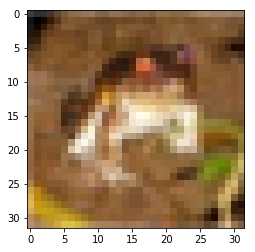

In [0]:
plt.figure()
plt.imshow(x_train[0])

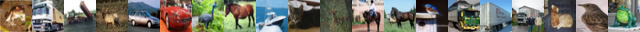

In [0]:
def showX(X):
    int_X_reshape = X.astype(np.uint8).reshape(-1,32,32, 3).swapaxes(0,1).reshape(32,-1,3)
    display(Image.fromarray(int_X_reshape, mode='RGB'))

showX(x_train[:20])

In [0]:
y_train[:20].T

array([[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]],
      dtype=uint8)

## Test central crop

(5000, 32, 32, 3)
(5000, 28, 28, 3)


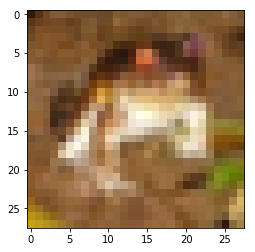

In [0]:
print(x_train.shape)
test = tf.image.central_crop(tf.convert_to_tensor(x_train), central_fraction=0.875)
print(test.shape)
plt.figure()
plt.imshow(test[0])

## Build Tensorflow Dataset

In [0]:
def preprocess(x, y, crop=False):
  x = tf.cast(x, tf.float32) / 127.5 - 1 
  
  if crop:
    x = tf.image.central_crop(x, central_fraction=0.875) # 32 -> 28
  x = tf.expand_dims(x, axis=-1)

  y = tf.one_hot(tf.squeeze(y,axis=-1), 10)
  
  return x, y

preprocessed_data = preprocess(x_train, y_train, crop=True)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 32

ds_train = tf.data.Dataset.from_tensor_slices(preprocessed_data)
ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
a_batch = next(iter(ds_train))
a_batch[0].shape, a_batch[1].shape

(TensorShape([32, 32, 32, 3, 1]), TensorShape([32, 10]))

In [0]:
# Define generator
LATENT_DIM = 100
class Generator(Model):
  def __init__(self):
    super().__init__()
    self.fc1 = layers.Dense(7*7*3*256, use_bias=False, input_shape=(LATENT_DIM + 10,))
    self.bn1 = layers.BatchNormalization()
    # deConV layer
    self.convtr_1 = layers.Conv3DTranspose(128, (5,5,3), strides=(1,1,1), padding="SAME", use_bias=False)
    self.bn2 = layers.BatchNormalization()
    # deConV layer
    self.convtr_2 = layers.Conv3DTranspose(64, (5,5,3), strides=(2,2,1), padding="SAME", use_bias=False)
    self.bn3 = layers.BatchNormalization()
    # deConV layer
    self.convtr_3 = layers.Conv3DTranspose(1, (5,5,3), strides=(2,2,1), padding="SAME", activation="tanh")
    
  @tf.function
  def call(self, inputs, is_training=False):
    x = layers.concatenate([inputs[0], inputs[1]]) # bs, latent_dim+10
    x = self.fc1(x)
    x = self.bn1(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = tf.reshape(x, shape=[-1,7,7,3,256])
    x = self.convtr_1(x) # bs, 7, 7, 3, 128
    x = self.bn2(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.convtr_2(x) # bs, 14, 14, 3, 64
    x = self.bn3(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    
    x = self.convtr_3(x) # bs, 28, 28, 3, 1(gray_scale)
    
    return x

In [0]:
### Q: Does D

In [0]:
# DEFINE Discriminator
class Discriminator(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = layers.Conv3D(64, (5,5,3), strides=(2,2,1), padding="SAME")
    self.drop1 = layers.Dropout(0.3)
    self.conv2 = layers.Conv3D(128, (5,5,3), strides=(2,2,1), padding="SAME")
    self.drop2 = layers.Dropout(0.3)
    self.flatten = layers.Flatten()
    self.fc1 = layers.Dense(50)
    self.bn = layers.BatchNormalization()
    self.fc2 = layers.Dense(1)
  @tf.function 
  def call(self, inputs, is_training=False):
    x = self.conv1(inputs[0]) # bs, 14, 14, 3, 64
    x = tf.nn.leaky_relu(x)
    x = self.drop1(x, training=is_training)
    x = self.conv2(x) # bs, 7, 7, 3, 128
    x = tf.nn.leaky_relu(x)
    x = self.drop2(x, training=is_training)
    x = self.flatten(x)
    print(x.shape)
    x = layers.concatenate([x, inputs[1]]) # bs, 7x7x3x128+10
    x = self.fc1(x) # bs, 50
    x = self.bn(x, training=is_training)
    x = tf.nn.leaky_relu(x)
    x = self.fc2(x) # bs, 1
    
    return x

In [0]:
generator = Generator()
discriminator = Discriminator()
generator.build(input_shape=[(None,LATENT_DIM),(None,10)])
discriminator.build(input_shape=[(None,28,28,3,1),(None,10)])

(None, 18816)
(None, 18816)


In [0]:
# Define both loss function
def generator_loss(generated_output):
  return tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_output), generated_output, from_logits=True))

In [0]:
def discriminator_loss(real_output, generated_output):
  
  real_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(real_output), real_output, from_logits=True))
  generated_loss = tf.reduce_mean(tf.losses.binary_crossentropy(tf.zeros_like(generated_output), generated_output, from_logits=True))

  total_loss = real_loss + generated_loss

  return total_loss

In [0]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [0]:
EPOCHS = 100
num_examples_to_generate = 20

# reuse this vector
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 LATENT_DIM])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
@tf.function
def train_step(images, labels):
  noise = tf.random.normal([labels.shape[0], LATENT_DIM]) # handle remainder
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, labels], is_training=True)

    real_output = discriminator([images, labels], is_training=True)
    generated_output = discriminator([generated_images, labels], is_training=True)

    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)
    
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def plot_numBar(images):
  images = np.uint8(images*127.5+128).clip(0, 255)[..., 0]
  concat_image = np.transpose(images, [1,0,2,3]).reshape((28,-1,3))
  display(Image.fromarray(concat_image))

In [0]:
for epoch in range(EPOCHS):
  start_time = time.time()
  for images, labels in ds_train:
    train_step(images, labels)
  
  fake = generator([random_vector_for_generation, condition_vector_generation], is_training=False)
  print(epoch, time.time()-start_time)
  plot_numBar(fake)

0 21.91372561454773


1 21.745352268218994


2 21.699889659881592


3 21.663223266601562


4 21.659684419631958


5 21.638113975524902


6 21.605131149291992


7 21.614381313323975


8 21.650962352752686


9 21.660836458206177


10 21.671146392822266


11 21.63961100578308


12 21.652091026306152


13 21.65479063987732


14 21.654338359832764


15 21.656685829162598


16 21.646570444107056


17 21.648545265197754


18 21.625070571899414


19 21.636878967285156


20 21.651296377182007


21 21.645916223526


22 21.63560914993286


23 21.646098613739014


24 21.643550395965576


25 21.64591383934021


26 21.67280149459839


27 21.662100791931152


28 21.66332983970642


29 21.67737627029419


30 21.642795085906982


31 21.62381863594055


32 21.663923263549805


33 21.62510108947754


34 21.634124040603638


35 21.646800756454468


36 21.694661617279053


37 21.6633141040802


38 21.644375562667847


39 21.640236616134644


40 21.599462747573853


41 21.544809341430664


42 21.610188722610474


43 21.607253789901733


44 21.550326108932495


45 21.553318977355957


46 21.574421167373657


47 21.549618005752563


48 21.577056884765625


49 21.563788890838623


50 21.57217502593994


51 21.556885480880737


52 21.595882654190063


53 21.567524433135986


54 21.576318502426147


55 21.559889793395996


56 21.583563089370728


57 21.562296628952026


58 21.580816507339478


59 21.578588247299194


60 21.56537938117981


61 21.58030891418457


62 21.545163869857788


63 21.57294201850891


64 21.550902605056763


65 21.53388810157776


66 21.539975881576538


67 21.606693983078003


68 21.574015140533447


69 21.518962860107422


70 21.52612280845642


71 21.55834174156189


72 21.565590858459473


73 21.54559850692749


74 21.558926582336426


75 21.53732180595398


76 21.575987100601196


77 21.5818612575531


78 21.588839769363403


79 21.584786891937256


80 21.581644535064697


81 21.583576440811157


82 21.585246801376343


83 21.55737853050232


84 21.581951141357422


85 21.58145236968994


86 21.580954551696777


87 21.583710432052612


88 21.589360237121582


89 21.56985855102539


90 21.578096866607666


91 21.568885803222656


92 21.59184217453003


93 21.573041915893555


94 21.55457615852356


95 21.549718856811523


96 21.584218740463257


97 21.58016848564148


98 21.5905704498291


99 21.568068742752075


In [0]:
MODEL_PATH = 'drive/My Drive/Colab Notebooks/mount/models/cifar10_GAN/alldata'
generator.save_weights(MODEL_PATH, save_format='tf')

In [0]:
# load & use model
new_model = Generator()
new_model.build(input_shape=[(None,LATENT_DIM),(None,10)])
noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
image, label = next(iter(ds_train))

# before load weights
bad_images = new_model([noise, label], is_training=True)
plot_numBar(bad_images)

In [0]:
new_model.load_weights(MODEL_PATH)

my_label = list([3,3,2,2,8,8,9,9,0,0])
noise = tf.random.normal([len(my_label), LATENT_DIM])
my_label = tf.one_hot(my_label, 10)

better = new_model([noise, my_label])

plot_numBar(better)